<a href="https://colab.research.google.com/github/HelloShagun/useful_libs/blob/main/examples/Water_types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

In [3]:
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize(project="ee-shagungargc2020")

True

In [13]:
"""
============================================================
WATER BODY CLASSIFICATION - TRAINING DATA SAMPLING (10 Classes)
Google Earth Engine Python API — MEMORY-OPTIMIZED VERSION
100 high-quality pixels per class from representative sites
Year: 2024 | Satellite: Sentinel-2 SR Harmonized
============================================================

SETUP:
  pip install earthengine-api
  earthengine authenticate

Then run this script.
============================================================
"""

import ee

# Initialize GEE
ee.Initialize(project='ee-shagungargc2020')  # Your project ID

# ============================================================
# DEFINE 10 CLASS SITES (smaller, tighter ROIs to reduce memory)
# ============================================================

CLASSES = {
    1: {
        'name': 'River',
        'site': 'Brahmaputra River, Assam, India',
        'roi': ee.Geometry.Polygon([[
            [90.00, 26.20], [90.15, 26.20],
            [90.15, 26.12], [90.00, 26.12], [90.00, 26.20]
        ]]),
        'strict_water': True
    },
    2: {
        'name': 'Reservoir',
        'site': 'Lake Mead, Nevada/Arizona, USA',
        'roi': ee.Geometry.Polygon([[
            [-114.78, 36.18], [-114.62, 36.18],
            [-114.62, 36.08], [-114.78, 36.08], [-114.78, 36.18]
        ]]),
        'strict_water': True
    },
    3: {
        'name': 'Urban_Lake',
        'site': 'Bangalore (Bengaluru), India',
        'roi': ee.Geometry.Polygon([[
            [77.58, 12.98], [77.66, 12.98],
            [77.66, 12.92], [77.58, 12.92], [77.58, 12.98]
        ]]),
        'strict_water': True
    },
    4: {
        'name': 'Aquaculture',
        'site': 'Mekong Delta, Vietnam',
        'roi': ee.Geometry.Polygon([[
            [106.58, 9.42], [106.70, 9.42],
            [106.70, 9.33], [106.58, 9.33], [106.58, 9.42]
        ]]),
        'strict_water': True
    },
    5: {
        'name': 'Glacial_Lake',
        'site': 'Khumbu/Everest Region, Nepal',
        'roi': ee.Geometry.Polygon([[
            [86.82, 27.96], [86.95, 27.96],
            [86.95, 27.88], [86.82, 27.88], [86.82, 27.96]
        ]]),
        'strict_water': True
    },
    6: {
        'name': 'Wetland',
        'site': 'Sundarbans, Bangladesh/India',
        'roi': ee.Geometry.Polygon([[
            [89.05, 21.95], [89.20, 21.95],
            [89.20, 21.85], [89.05, 21.85], [89.05, 21.95]
        ]]),
        'strict_water': False
    },
    7: {
        'name': 'Salt_Evaporation_Pond',
        'site': 'Great Salt Lake, Utah, USA',
        'roi': ee.Geometry.Polygon([[
            [-112.22, 41.18], [-112.08, 41.18],
            [-112.08, 41.10], [-112.22, 41.10], [-112.22, 41.18]
        ]]),
        'strict_water': True
    },
    8: {
        'name': 'Floodplain',
        'site': 'Tonle Sap Floodplain, Cambodia',
        'roi': ee.Geometry.Polygon([[
            [104.55, 13.05], [104.70, 13.05],
            [104.70, 12.95], [104.55, 12.95], [104.55, 13.05]
        ]]),
        'strict_water': False
    },
    9: {
        'name': 'Oxbow_Lake',
        'site': 'Mississippi River Oxbows, Louisiana, USA',
        'roi': ee.Geometry.Polygon([[
            [-91.22, 31.26], [-91.10, 31.26],
            [-91.10, 31.18], [-91.22, 31.18], [-91.22, 31.26]
        ]]),
        'strict_water': True
    },
    10: {
        'name': 'Irrigation_Canal',
        'site': 'Indus Basin Canals, Punjab, Pakistan',
        'roi': ee.Geometry.Polygon([[
            [71.88, 28.55], [72.02, 28.55],
            [72.02, 28.45], [71.88, 28.45], [71.88, 28.55]
        ]]),
        'strict_water': True
    }
}

# ============================================================
# PROCESSING FUNCTIONS
# ============================================================

SPECTRAL_BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
INDEX_BANDS = ['NDWI', 'MNDWI']
ALL_BANDS = SPECTRAL_BANDS + INDEX_BANDS


def mask_s2_clouds(image):
    scl = image.select('SCL')
    mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(7)).Or(scl.eq(11))
    return image.updateMask(mask)


def add_water_indices(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    return image.addBands([ndwi, mndwi])


def get_water_mask(composite, strict=True):
    if strict:
        return (composite.select('MNDWI').gt(0.1)
                .And(composite.select('NDWI').gt(0.0)))
    else:
        return (composite.select('MNDWI').gt(-0.1)
                .And(composite.select('NDWI').gt(-0.2)))


def build_composite(roi):
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate('2024-01-01', '2024-12-31')
          .filterBounds(roi)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .select(SPECTRAL_BANDS + ['SCL'])
          .map(mask_s2_clouds)
          .map(add_water_indices))
    return s2.median().clip(roi)


def sample_class(class_id, class_info, num_points=100):
    roi = class_info['roi']
    strict = class_info['strict_water']
    class_name = class_info['name']

    composite = build_composite(roi)
    water_mask = get_water_mask(composite, strict=strict)
    masked = composite.updateMask(water_mask)

    samples = masked.select(ALL_BANDS).sample(
        region=roi,
        scale=10,
        numPixels=num_points * 2,  # oversample then limit
        seed=42,
        geometries=True,
        tileScale=4  # KEY: reduces memory by processing in smaller tiles
    ).limit(num_points)

    samples = samples.map(lambda f: f.set({
        'class_name': class_name,
        'class_id': class_id,
        'site': class_info['site']
    }))

    return samples


# ============================================================
# OPTION A: EXPORT EACH CLASS SEPARATELY (safest for memory)
# ============================================================

print("=" * 60)
print("EXPORTING EACH CLASS SEPARATELY TO GOOGLE DRIVE")
print("=" * 60)

tasks = []

for class_id, class_info in CLASSES.items():
    print(f"  Submitting Class {class_id:2d}: {class_info['name']:25s} | {class_info['site']}")

    samples = sample_class(class_id, class_info, num_points=100)

    task = ee.batch.Export.table.toDrive(
        collection=samples,
        description=f'WaterSamples_C{class_id:02d}_{class_info["name"]}',
        fileNamePrefix=f'water_samples_C{class_id:02d}_{class_info["name"]}',
        folder='water_body_samples',  # Creates folder in your Drive
        fileFormat='CSV'
    )
    task.start()
    tasks.append((class_id, class_info['name'], task))

print("=" * 60)
print(f"  {len(tasks)} export tasks submitted!")
print("  Files will appear in Google Drive folder: 'water_body_samples'")
print()

# ============================================================
# OPTION B: ALSO TRY MERGED EXPORT (may work with smaller ROIs)
# ============================================================

print("Also attempting merged export...")
try:
    all_samples = None
    for class_id, class_info in CLASSES.items():
        samples = sample_class(class_id, class_info, num_points=100)
        if all_samples is None:
            all_samples = samples
        else:
            all_samples = all_samples.merge(samples)

    task_merged = ee.batch.Export.table.toDrive(
        collection=all_samples,
        description='Water_Body_10Class_ALL_2024',
        fileNamePrefix='water_body_10class_samples_2024',
        folder='water_body_samples',
        fileFormat='CSV'
    )
    task_merged.start()
    print("  Merged export submitted: water_body_10class_samples_2024.csv")
except Exception as e:
    print(f"  Merged export failed (expected if memory limited): {e}")
    print("  No worries — use the individual class exports instead.")

# ============================================================
# CHECK TASK STATUS
# ============================================================

print()
print("=" * 60)
print("CHECKING TASK STATUS...")
print("=" * 60)

for class_id, name, task in tasks:
    status = task.status()
    print(f"  C{class_id:02d} {name:25s}: {status['state']}")

print()
print("Tasks are running server-side. Check GEE Tasks or Drive in a few minutes.")
print()
print("Once exported, run the merge script below to combine CSVs,")
print("then run 02_plot_umap_water_bodies.py")
print()

# ============================================================
# HELPER: MERGE INDIVIDUAL CSVs (run after download)
# ============================================================

MERGE_SCRIPT = """
# ============================================================
# Run this AFTER downloading the 10 CSVs from Google Drive
# to merge them into a single CSV for UMAP plotting
# ============================================================
# Save as: merge_csvs.py

import pandas as pd
import glob
import os

csv_dir = '.'  # or path to your downloaded CSVs
pattern = os.path.join(csv_dir, 'water_samples_C*.csv')
files = sorted(glob.glob(pattern))

if not files:
    print("No files found! Make sure CSVs are in current directory.")
else:
    dfs = [pd.read_csv(f) for f in files]
    merged = pd.concat(dfs, ignore_index=True)
    out = 'water_body_10class_samples_2024.csv'
    merged.to_csv(out, index=False)
    print(f"Merged {len(files)} files → {out} ({len(merged)} rows)")
"""

print(MERGE_SCRIPT)

print("=" * 60)
print("SITE SUMMARY")
print("=" * 60)
for cid, cinfo in CLASSES.items():
    print(f"  {cid:2d}. {cinfo['name']:25s} → {cinfo['site']}")
print("=" * 60)

EXPORTING EACH CLASS SEPARATELY TO GOOGLE DRIVE
  Submitting Class  1: River                     | Brahmaputra River, Assam, India
  Submitting Class  2: Reservoir                 | Lake Mead, Nevada/Arizona, USA
  Submitting Class  3: Urban_Lake                | Bangalore (Bengaluru), India
  Submitting Class  4: Aquaculture               | Mekong Delta, Vietnam
  Submitting Class  5: Glacial_Lake              | Khumbu/Everest Region, Nepal
  Submitting Class  6: Wetland                   | Sundarbans, Bangladesh/India
  Submitting Class  7: Salt_Evaporation_Pond     | Great Salt Lake, Utah, USA
  Submitting Class  8: Floodplain                | Tonle Sap Floodplain, Cambodia
  Submitting Class  9: Oxbow_Lake                | Mississippi River Oxbows, Louisiana, USA
  Submitting Class 10: Irrigation_Canal          | Indus Basin Canals, Punjab, Pakistan
  10 export tasks submitted!
  Files will appear in Google Drive folder: 'water_body_samples'

Also attempting merged export...
  Merg

In [10]:


##### collab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
import pandas as pd
import glob
import os

csv_dir = '/content/drive/MyDrive/water_body_samples'  # Change to your download path if needed

pattern = os.path.join(csv_dir, 'water_samples_C*.csv')
files = sorted(glob.glob(pattern))

if not files:
    print("No files found matching 'water_samples_C*.csv'")
    print("Make sure the CSVs are in the current directory.")
else:
    dfs = []
    for f in files:
        try:
            if os.path.getsize(f) < 10:
                print(f"  {os.path.basename(f):45s} → EMPTY (skipped)")
                continue
            df = pd.read_csv(f)
            if len(df) == 0:
                print(f"  {os.path.basename(f):45s} → 0 rows (skipped)")
                continue
            print(f"  {os.path.basename(f):45s} → {len(df)} rows")
            dfs.append(df)
        except Exception as e:
            print(f"  {os.path.basename(f):45s} → ERROR: {e} (skipped)")

    if dfs:
        merged = pd.concat(dfs, ignore_index=True)
        out = 'water_body_10class_samples_2024.csv'
        merged.to_csv(out, index=False)
        print(f"\nMerged {len(dfs)} files → {out} ({len(merged)} total rows)")
        print(f"Classes present: {sorted(merged['class_id'].unique())}")
    else:
        print("\nNo valid data found in any file!")


  water_samples_C01_River.csv                   → 2 rows
  water_samples_C02_Reservoir.csv               → 59 rows
  water_samples_C03_Urban_Lake.csv              → EMPTY (skipped)
  water_samples_C04_Aquaculture.csv             → 100 rows
  water_samples_C05_Glacial_Lake.csv            → 28 rows
  water_samples_C06_Wetland.csv                 → 64 rows
  water_samples_C07_Salt_Evaporation_Pond.csv   → 8 rows
  water_samples_C08_Floodplain.csv              → EMPTY (skipped)
  water_samples_C09_Oxbow_Lake.csv              → EMPTY (skipped)
  water_samples_C10_Irrigation_Canal.csv        → EMPTY (skipped)

Merged 6 files → water_body_10class_samples_2024.csv (261 total rows)
Classes present: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


Loaded 261 samples, 6 classes
 class_id            class_name  count
        1                 River      2
        2             Reservoir     59
        4           Aquaculture    100
        5          Glacial_Lake     28
        6               Wetland     64
        7 Salt_Evaporation_Pond      8


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


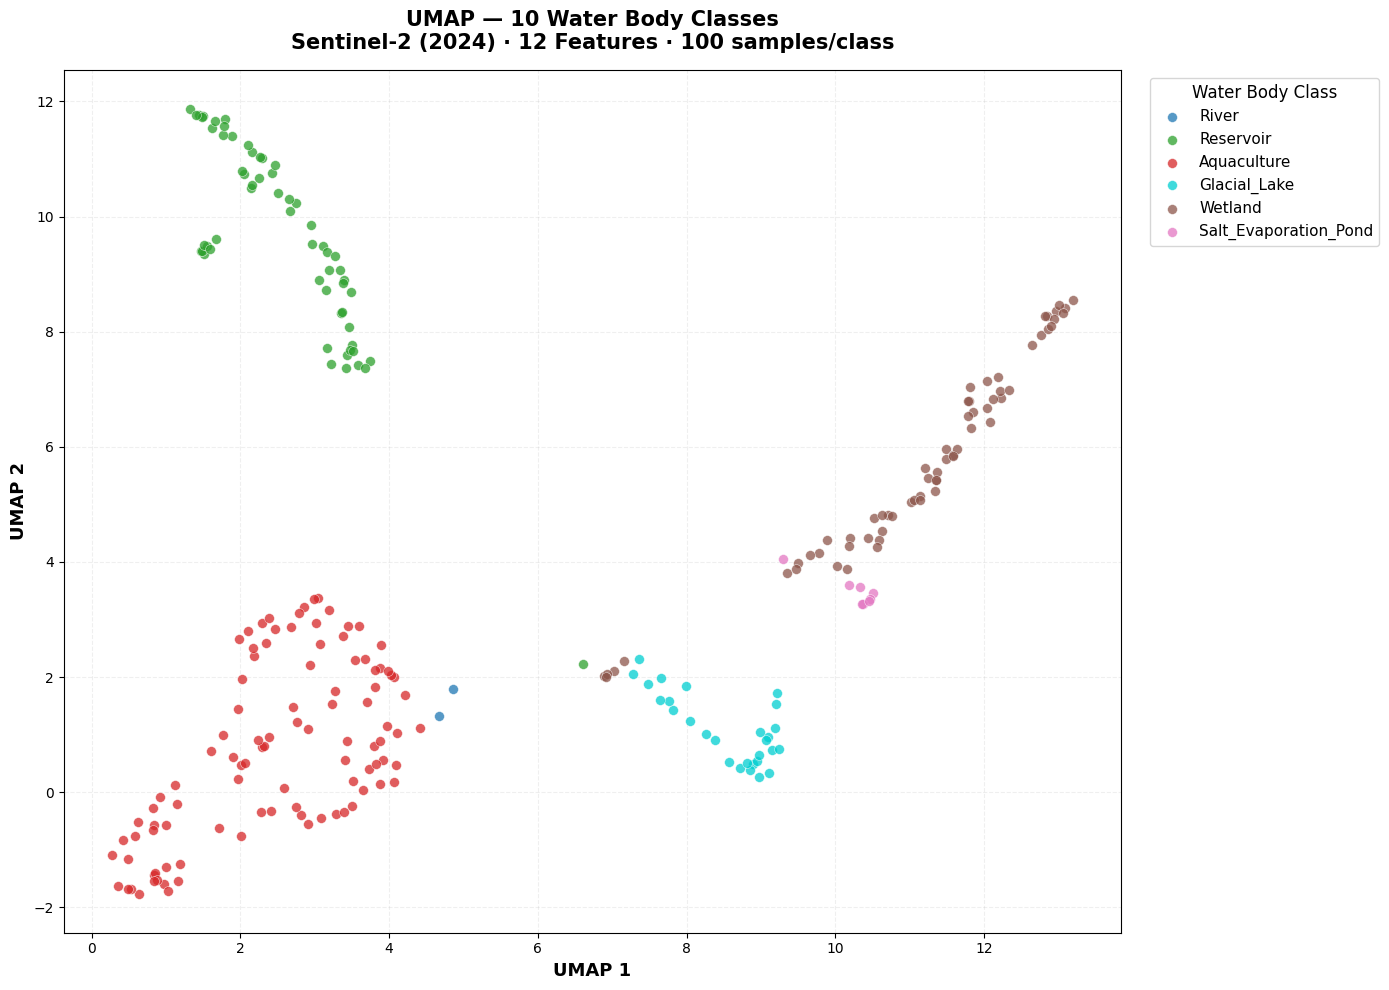

In [18]:
# ============================================================
# UMAP Visualization — 10 Water Body Classes
# Single cell for Jupyter Notebook
# ============================================================
# pip install umap-learn (if not already installed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap

# ---------- LOAD DATA ----------
csv_path = '/content/water_body_10class_samples_2024.csv'  # <-- update path if needed
df = pd.read_csv(csv_path)

# Clean up GEE columns
drop_cols = [c for c in df.columns if c.startswith('system:') or c == '.geo']
df = df.drop(columns=drop_cols, errors='ignore')
df['class_id'] = df['class_id'].astype(int)

# Feature bands
BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','NDWI','MNDWI']
df = df.dropna(subset=BANDS)

print(f"Loaded {len(df)} samples, {df['class_id'].nunique()} classes")
print(df.groupby(['class_id','class_name']).size().reset_index(name='count').to_string(index=False))

# ---------- UMAP ----------
X = StandardScaler().fit_transform(df[BANDS].values)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.2,
    metric='euclidean',
    n_components=2,
    random_state=42
)
embedding = reducer.fit_transform(X)
df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]

# ---------- PLOT ----------
CLASS_COLORS = {
    1:  '#1f77b4',   # River
    2:  '#2ca02c',   # Reservoir
    3:  '#ff7f0e',   # Urban Lake
    4:  '#d62728',   # Aquaculture
    5:  '#00CED1',   # Glacial Lake
    6:  '#8c564b',   # Wetland
    7:  '#e377c2',   # Salt Evap Pond
    8:  '#7f7f7f',   # Floodplain
    9:  '#bcbd22',   # Oxbow Lake
    10: '#17becf',   # Irrigation Canal
}

fig, ax = plt.subplots(figsize=(14, 10))

for cid in sorted(df['class_id'].unique()):
    mask = df['class_id'] == cid
    cname = df.loc[mask, 'class_name'].iloc[0]
    ax.scatter(
        df.loc[mask, 'UMAP_1'],
        df.loc[mask, 'UMAP_2'],
        c=CLASS_COLORS.get(cid, '#333'),
        label=cname,
        s=50, alpha=0.75,
        edgecolors='white', linewidths=0.4,
        zorder=3
    )

ax.set_xlabel('UMAP 1', fontsize=13, fontweight='bold')
ax.set_ylabel('UMAP 2', fontsize=13, fontweight='bold')
ax.set_title(
    'UMAP — 10 Water Body Classes\n'
    'Sentinel-2 (2024) · 12 Features · 100 samples/class',
    fontsize=15, fontweight='bold', pad=15
)
ax.legend(
    loc='upper left', bbox_to_anchor=(1.02, 1),
    fontsize=11, frameon=True, title='Water Body Class', title_fontsize=12
)
ax.grid(True, alpha=0.2, linestyle='--')
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('umap_water_bodies_10class.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
!pip install umap-learn pandas numpy matplotlib seaborn scikit-learn

In [19]:
"""
============================================================
WATER BODY SPECTRAL + EMBEDDING EXTRACTION TOOLKIT
============================================================
Modular functions for:
  1. Loading sample points from CSV
  2. Building Sentinel-2 composites
  3. Computing spectral indices (NDWI, MNDWI, etc.)
  4. Loading AlphaEarth Foundations 64-dim embeddings
  5. Extracting values at points
  6. Exporting results
  7. UMAP comparison (indices vs embeddings)

Each function is independent and reusable.
============================================================

SETUP:
  pip install earthengine-api pandas numpy
  For UMAP: pip install umap-learn matplotlib seaborn scikit-learn

USAGE (Jupyter):
  from water_extraction_toolkit import *
  df, tasks = run_extraction('your_points.csv')
============================================================
"""

import ee
import pandas as pd
import numpy as np
from datetime import datetime

ee.Initialize(project='ee-shagungargc2020')


# ============================================================
# 1. DATA LOADING
# ============================================================

def load_sample_points(csv_path):
    """
    Load sample points CSV and return a clean DataFrame.

    Parameters:
        csv_path (str): Path to CSV with [class_id, class_name, latitude, longitude]

    Returns:
        pd.DataFrame
    """
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip().str.lower()

    required = ['class_id', 'class_name', 'latitude', 'longitude']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}. Found: {list(df.columns)}")

    df['class_id'] = df['class_id'].astype(int)

    print(f"Loaded {len(df)} points from {csv_path}")
    print(f"Classes:")
    for cid in sorted(df['class_id'].unique()):
        cname = df.loc[df['class_id'] == cid, 'class_name'].iloc[0]
        count = len(df[df['class_id'] == cid])
        print(f"  {cid}: {cname} ({count} pts)")

    return df


def df_to_fc(df):
    """
    Convert DataFrame with lat/lon to GEE FeatureCollection.

    Parameters:
        df (pd.DataFrame): Must have latitude, longitude, class_id, class_name

    Returns:
        ee.FeatureCollection
    """
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point([float(row['longitude']), float(row['latitude'])])
        props = {
            'class_id': int(row['class_id']),
            'class_name': str(row['class_name']),
            'latitude': float(row['latitude']),
            'longitude': float(row['longitude'])
        }
        features.append(ee.Feature(geom, props))

    fc = ee.FeatureCollection(features)
    print(f"Created FeatureCollection with {len(features)} points")
    return fc


# ============================================================
# 2. SENTINEL-2 COMPOSITE
# ============================================================

def mask_s2_clouds(image):
    """Mask clouds/shadows using SCL band."""
    scl = image.select('SCL')
    mask = (scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))
            .Or(scl.eq(7)).Or(scl.eq(11)))
    return image.updateMask(mask)


def get_s2_collection(roi, start_date, end_date, cloud_pct=10):
    """Get filtered, cloud-masked Sentinel-2 SR collection."""
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL']
    return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(roi)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_pct))
            .select(bands)
            .map(mask_s2_clouds))


def build_composite(roi, start_date='2024-01-01', end_date='2024-12-31',
                    cloud_pct=10, method='median'):
    """Build cloud-free Sentinel-2 composite."""
    col = get_s2_collection(roi, start_date, end_date, cloud_pct)
    if method == 'median':
        return col.median()
    elif method == 'mean':
        return col.mean()
    elif method == 'mosaic':
        return col.mosaic()
    else:
        raise ValueError(f"Unknown method: {method}")


# ============================================================
# 3. SPECTRAL INDICES
# ============================================================

def add_ndwi(image):
    """NDWI = (Green - NIR) / (Green + NIR)"""
    return image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))

def add_mndwi(image):
    """MNDWI = (Green - SWIR1) / (Green + SWIR1)"""
    return image.addBands(image.normalizedDifference(['B3', 'B11']).rename('MNDWI'))

def add_awei_sh(image):
    """AWEIsh — Feyisa 2014"""
    awei = (image.select('B3').multiply(4)
            .subtract(image.select('B11').multiply(4))
            .subtract(image.select('B8').multiply(0.25))
            .subtract(image.select('B12').multiply(2.75))
            .rename('AWEIsh'))
    return image.addBands(awei)

def add_ndvi(image):
    """NDVI = (NIR - Red) / (NIR + Red)"""
    return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))

def add_ndbi(image):
    """NDBI = (SWIR1 - NIR) / (SWIR1 + NIR)"""
    return image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI'))

def add_bsi(image):
    """BSI — Bare Soil Index"""
    bsi = (image.select('B11').add(image.select('B4'))
           .subtract(image.select('B8').add(image.select('B2')))
           .divide(image.select('B11').add(image.select('B4'))
                   .add(image.select('B8')).add(image.select('B2')))
           .rename('BSI'))
    return image.addBands(bsi)

def add_all_indices(image):
    """Add all 6 spectral indices."""
    for fn in [add_ndwi, add_mndwi, add_awei_sh, add_ndvi, add_ndbi, add_bsi]:
        image = fn(image)
    return image


# Band name constants
S2_BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
INDEX_BANDS = ['NDWI', 'MNDWI', 'AWEIsh', 'NDVI', 'NDBI', 'BSI']
S2_ALL_BANDS = S2_BANDS + INDEX_BANDS
AE_BANDS = [f'A{i:02d}' for i in range(64)]  # A00 ... A63


# ============================================================
# 4. ALPHAEARTH FOUNDATIONS EMBEDDINGS
# ============================================================

def get_alphaearth_image(year=2024, roi=None):
    """
    Load AlphaEarth Foundations annual satellite embedding image.

    64 bands (A00-A63) at 10m resolution. Each pixel is a learned
    embedding encoding multi-sensor temporal trajectories for the year.

    Collection: GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL
    Available years: 2017-2024

    Parameters:
        year (int): Year
        roi (ee.Geometry, optional): Region to filter

    Returns:
        ee.Image (64 bands)
    """
    collection = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
    filtered = collection.filterDate(f'{year}-01-01', f'{year + 1}-01-01')

    if roi is not None:
        filtered = filtered.filterBounds(roi)

    image = filtered.mosaic()
    print(f"Loaded AlphaEarth embeddings for {year} (64 bands: A00-A63)")
    return image


# ============================================================
# 5. EXTRACTION
# ============================================================

def extract_at_points(image, fc, bands=None, scale=10, properties=None):
    """
    Extract band values at point locations.

    Parameters:
        image (ee.Image): Image to sample
        fc (ee.FeatureCollection): Points
        bands (list): Bands to extract (None = all)
        scale (int): Resolution in meters
        properties (list): Properties to keep from fc

    Returns:
        ee.FeatureCollection
    """
    if properties is None:
        properties = ['class_id', 'class_name', 'latitude', 'longitude']
    if bands is not None:
        image = image.select(bands)

    return image.sampleRegions(
        collection=fc,
        properties=properties,
        scale=scale,
        tileScale=4,
        geometries=True
    )


def extract_s2_at_points(fc, start_date='2024-01-01', end_date='2024-12-31',
                         cloud_pct=10, scale=10):
    """Extract S2 bands + all indices at points."""
    roi = fc.geometry().bounds().buffer(10000)
    composite = add_all_indices(build_composite(roi, start_date, end_date, cloud_pct))
    print(f"Extracting S2: {S2_ALL_BANDS}")
    return extract_at_points(composite, fc, bands=S2_ALL_BANDS, scale=scale)


def extract_alphaearth_at_points(fc, year=2024, scale=10):
    """Extract AlphaEarth 64-dim embeddings at points."""
    roi = fc.geometry().bounds().buffer(10000)
    ae = get_alphaearth_image(year, roi)
    print(f"Extracting AlphaEarth: A00-A63")
    return extract_at_points(ae, fc, bands=AE_BANDS, scale=scale)


def extract_all_at_points(fc, start_date='2024-01-01', end_date='2024-12-31',
                          cloud_pct=10, ae_year=2024, scale=10):
    """
    Extract BOTH S2 (bands+indices) AND AlphaEarth embeddings.
    Stacks into a single image before sampling.

    Returns:
        ee.FeatureCollection with S2_ALL_BANDS + AE_BANDS columns
    """
    roi = fc.geometry().bounds().buffer(10000)

    composite = add_all_indices(build_composite(roi, start_date, end_date, cloud_pct))
    ae = get_alphaearth_image(ae_year, roi)

    stacked = composite.select(S2_ALL_BANDS).addBands(ae.select(AE_BANDS))

    all_bands = S2_ALL_BANDS + AE_BANDS
    print(f"Extracting {len(all_bands)} bands total:")
    print(f"  S2 spectral:  {S2_BANDS}")
    print(f"  S2 indices:   {INDEX_BANDS}")
    print(f"  AlphaEarth:   A00-A63 (64 bands)")

    return extract_at_points(stacked, fc, bands=all_bands, scale=scale)


# ============================================================
# 6. GEE <-> PANDAS
# ============================================================

def fc_to_df(fc, max_features=5000):
    """Convert GEE FeatureCollection to Pandas DataFrame."""
    size = fc.size().getInfo()
    print(f"Downloading {size} features...")

    if size > max_features:
        raise ValueError(f"Too many features ({size}). Export to Drive instead.")

    features = fc.getInfo()['features']
    rows = []
    for f in features:
        props = f['properties']
        if f.get('geometry') and f['geometry'].get('coordinates'):
            coords = f['geometry']['coordinates']
            props['longitude'] = coords[0]
            props['latitude'] = coords[1]
        rows.append(props)

    df = pd.DataFrame(rows)
    print(f"DataFrame shape: {df.shape}")
    return df


# ============================================================
# 7. EXPORT
# ============================================================

def export_to_drive(fc, filename, folder='water_body_extraction',
                    selectors=None, file_format='CSV'):
    """Export FeatureCollection to Google Drive."""
    params = {
        'collection': fc,
        'description': filename,
        'fileNamePrefix': filename,
        'folder': folder,
        'fileFormat': file_format,
    }
    if selectors:
        params['selectors'] = selectors
    task = ee.batch.Export.table.toDrive(**params)
    task.start()
    print(f"Export started: {filename} → Drive/{folder}/")
    return task


def check_tasks(tasks):
    """Print status of export tasks."""
    for i, task in enumerate(tasks):
        status = task.status()
        print(f"  Task {i + 1}: {status['description']} → {status['state']}")


# ============================================================
# 8. FULL PIPELINE
# ============================================================

def run_extraction(csv_path, start_date='2024-01-01', end_date='2024-12-31',
                   cloud_pct=10, ae_year=2024, scale=10,
                   export_drive=True, return_df=True):
    """
    Full pipeline: load → extract S2 + AlphaEarth → export/download.

    Returns:
        (pd.DataFrame, list_of_tasks) or (ee.FeatureCollection, list_of_tasks)
    """
    print("=" * 60)
    print("STEP 1: Loading sample points")
    print("=" * 60)
    df = load_sample_points(csv_path)
    fc = df_to_fc(df)

    print("\n" + "=" * 60)
    print("STEP 2: Extracting S2 + AlphaEarth at points")
    print("=" * 60)
    sampled = extract_all_at_points(fc, start_date, end_date, cloud_pct, ae_year, scale)

    tasks = []
    if export_drive:
        print("\n" + "=" * 60)
        print("STEP 3: Exporting to Drive")
        print("=" * 60)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M')
        selectors = ['class_id', 'class_name', 'latitude', 'longitude'] + S2_ALL_BANDS + AE_BANDS
        task = export_to_drive(sampled, f'water_s2_alphaearth_{timestamp}', selectors=selectors)
        tasks.append(task)

    if return_df:
        print("\n" + "=" * 60)
        print("STEP 4: Downloading as DataFrame")
        print("=" * 60)
        result_df = fc_to_df(sampled)
        result_df['class_id'] = result_df['class_id'].astype(int)
        print(f"\nDone! Shape: {result_df.shape}")
        return result_df, tasks

    return sampled, tasks

STEP 1: Loading sample points
Loaded 315 points from /content/drive/MyDrive/water_body_sample_points_6class.csv
Classes:
  1: GLOF (51 pts)
  2: Wetland (58 pts)
  3: Lagoon (50 pts)
  4: Lake_USA (56 pts)
  5: Urban_Lake (50 pts)
  6: Aquaculture (50 pts)
Created FeatureCollection with 315 points

STEP 2: Extracting S2 + AlphaEarth at points
Loaded AlphaEarth embeddings for 2024 (64 bands: A00-A63)
Extracting 80 bands total:
  S2 spectral:  ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
  S2 indices:   ['NDWI', 'MNDWI', 'AWEIsh', 'NDVI', 'NDBI', 'BSI']
  AlphaEarth:   A00-A63 (64 bands)

STEP 3: Exporting to Drive
Export started: water_s2_alphaearth_20260208_0159 → Drive/water_body_extraction/

STEP 4: Downloading as DataFrame
DataFrame shape: (314, 84)

Done! Shape: (314, 84)
Saved: (314, 84)
S2 bands: ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'BSI']
Indices: ['AWEIsh', 'BSI', 'MNDWI', 'NDBI', 'NDVI', 'NDWI']
AlphaEarth: ['A00', 'A01', 'A02', 'A

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Water Indices Only: 2 features → UMAP done


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  S2 Bands + All Indices: 16 features → UMAP done


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  AlphaEarth Embeddings: 64 features → UMAP done


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  S2 + AlphaEarth Combined: 80 features → UMAP done


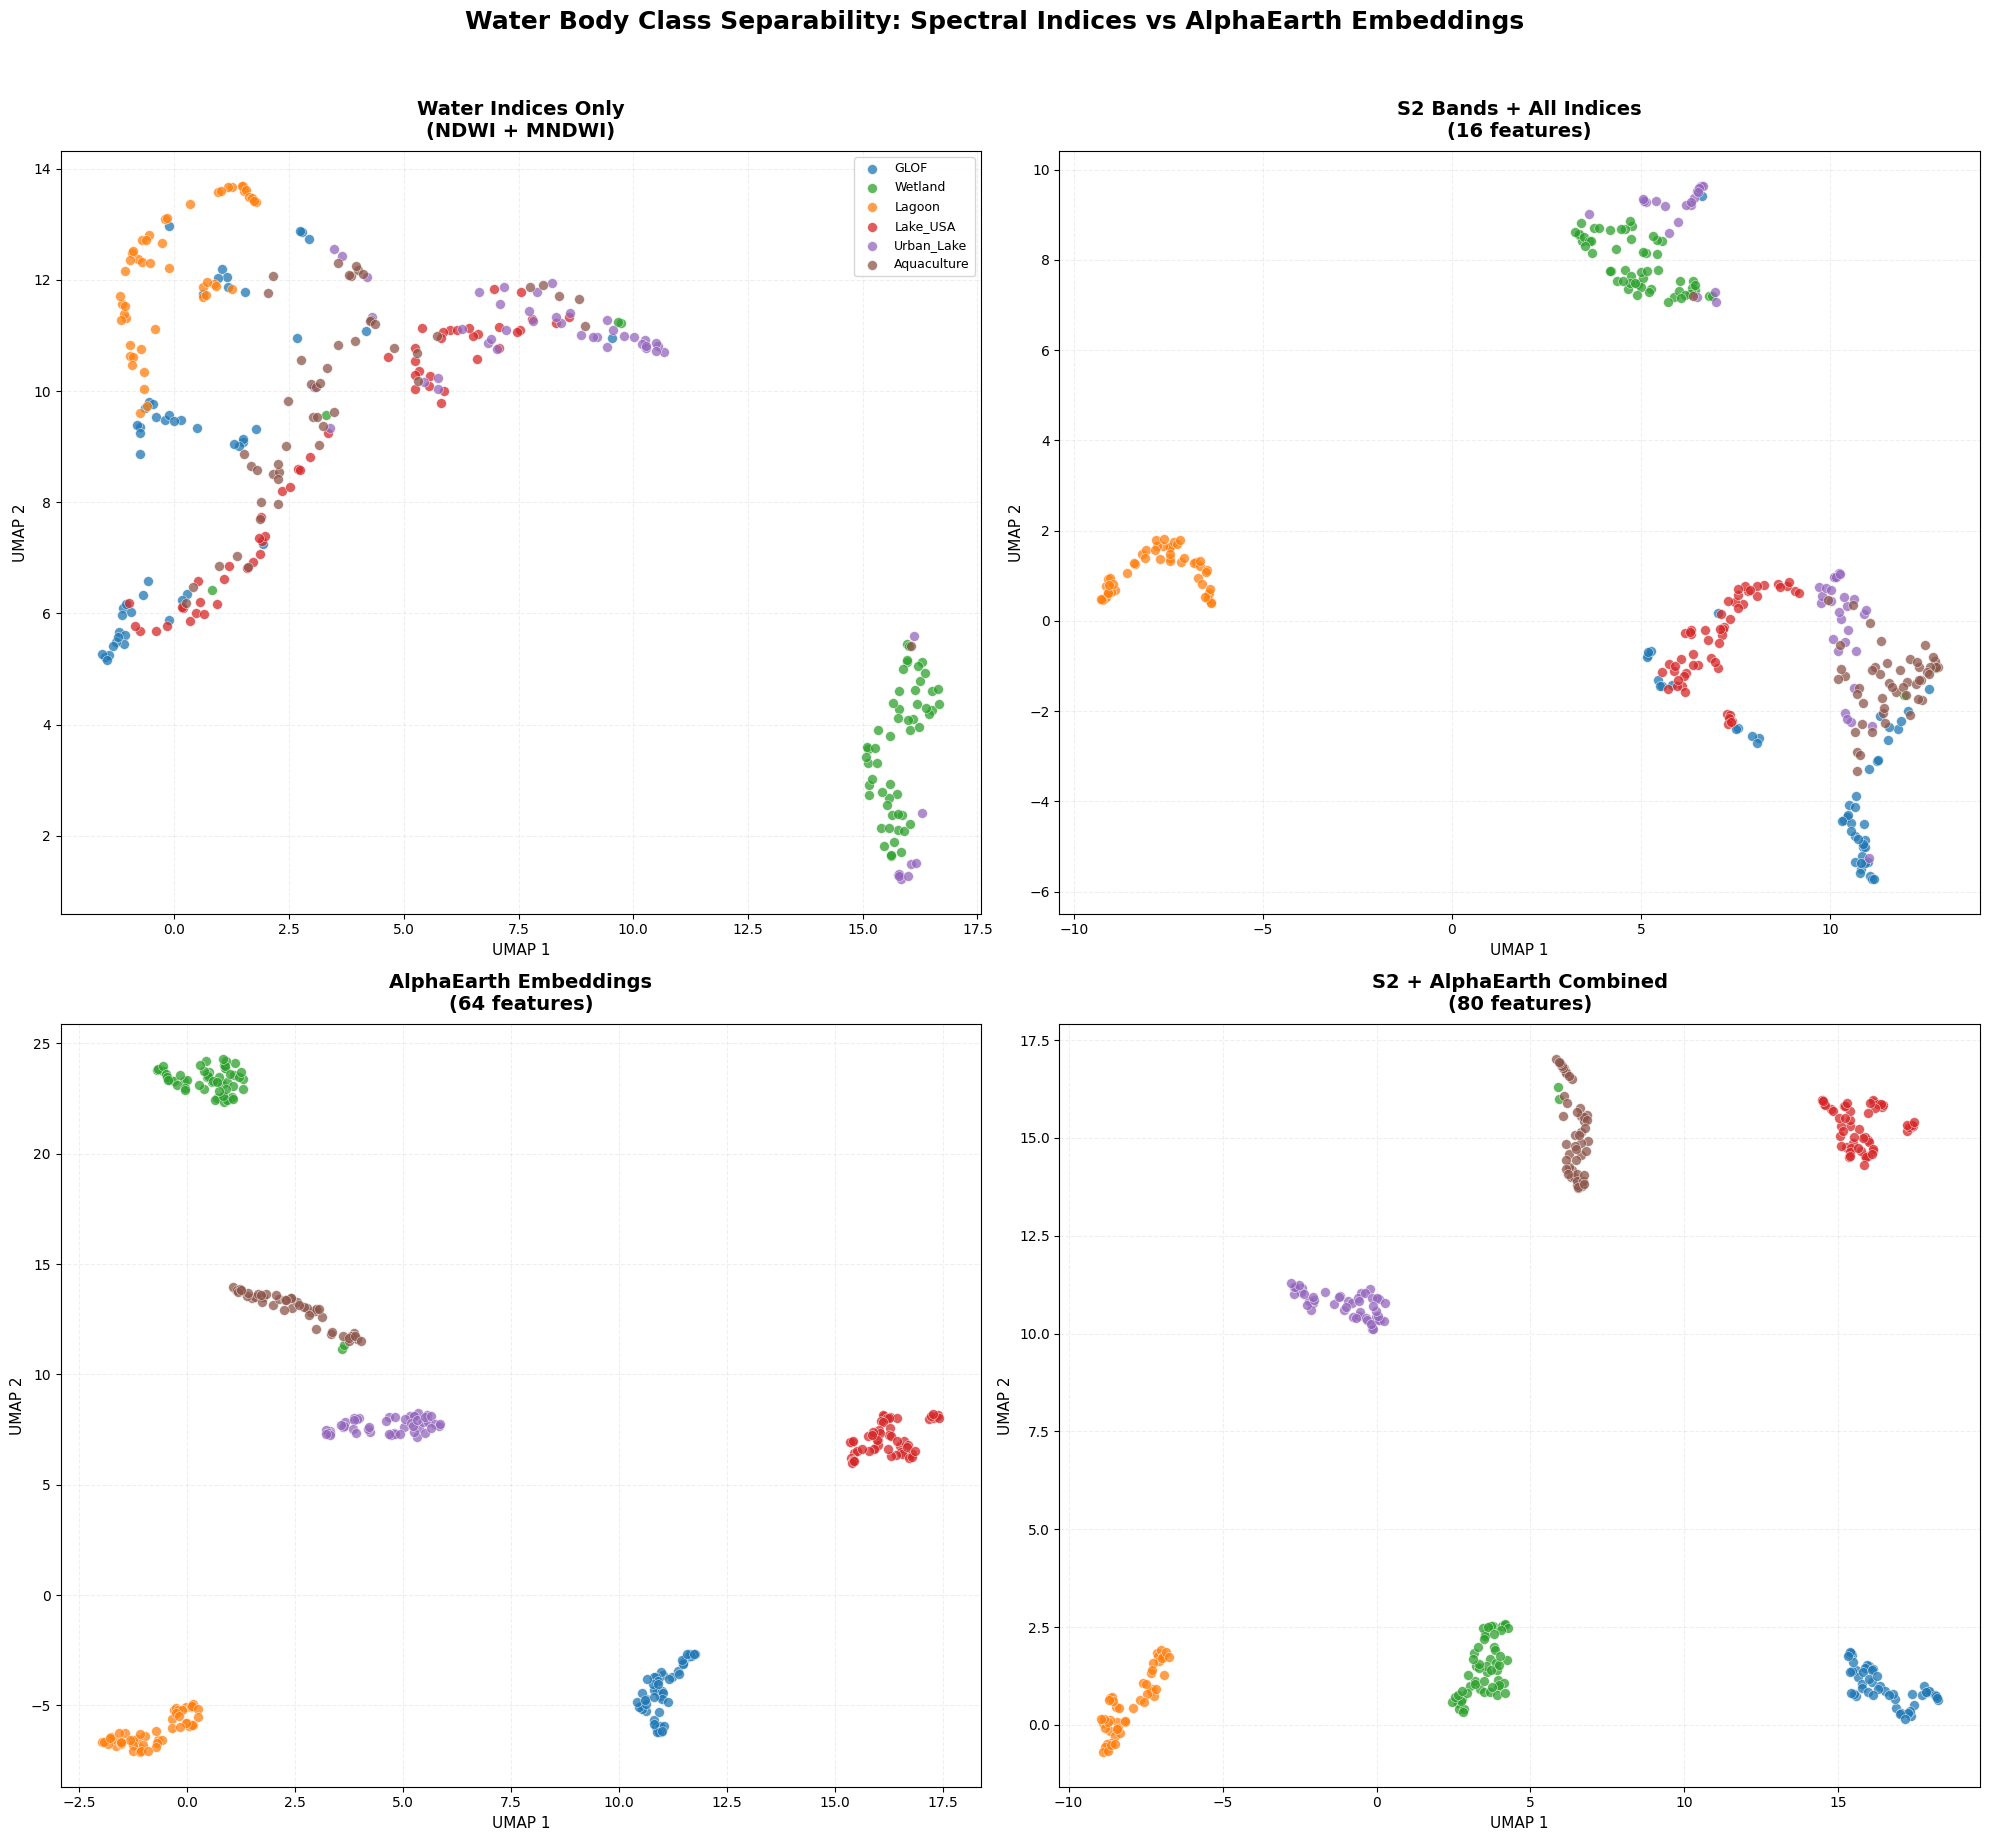


SILHOUETTE SCORES (higher = better separation)
  Water Indices Only                 : 0.1572
  S2 Bands + All Indices             : 0.2780
  AlphaEarth Embeddings              : 0.5903
  S2 + AlphaEarth Combined           : 0.5468


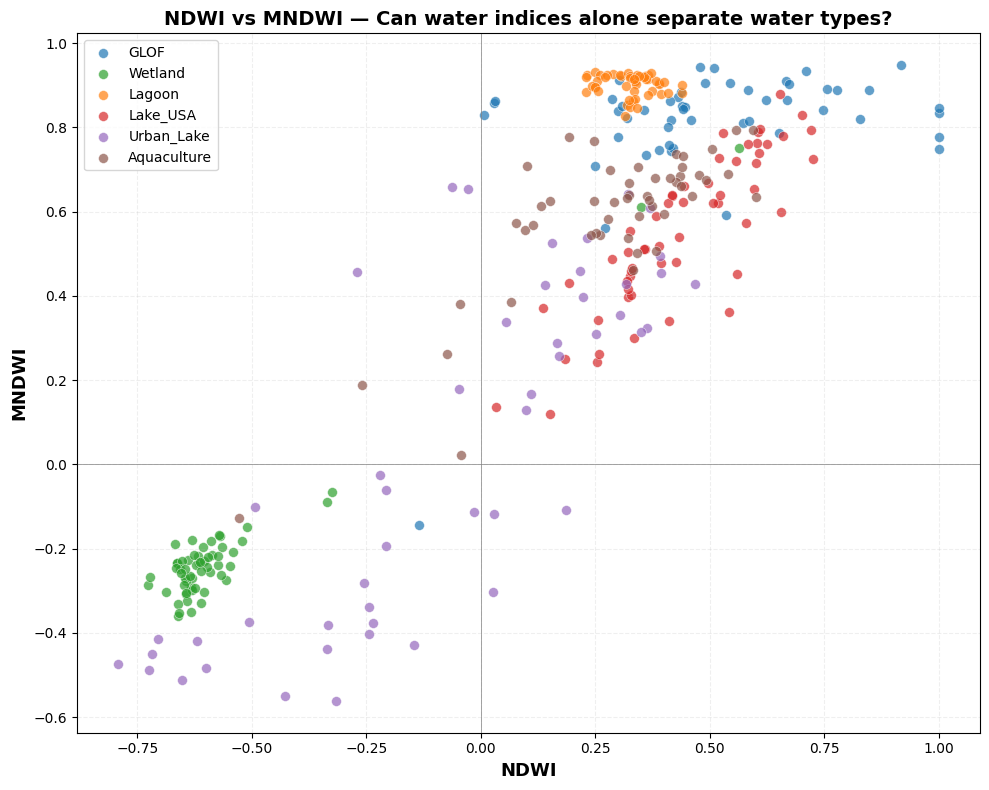

In [21]:
# ============================================================
# CELL 1: Import toolkit
# ============================================================
#from water_extraction_toolkit import *

# ============================================================
# CELL 2: Run full extraction (S2 + AlphaEarth)
# ============================================================
# This extracts 16 S2 bands/indices + 64 AlphaEarth bands = 80 features per point

df, tasks = run_extraction(
    csv_path='/content/drive/MyDrive/water_body_sample_points_6class.csv',  # <-- your CSV
    start_date='2024-01-01',
    end_date='2024-12-31',
    cloud_pct=10,
    ae_year=2024,
    scale=10,
    export_drive=True,
    return_df=True
)

df.head()

# ============================================================
# CELL 3: Save locally as backup
# ============================================================
df.to_csv('water_body_s2_alphaearth_extracted.csv', index=False)
print(f"Saved: {df.shape}")

# ============================================================
# CELL 4: Check what we have
# ============================================================
print("S2 bands:", [c for c in df.columns if c.startswith('B')])
print("Indices:", [c for c in df.columns if c in INDEX_BANDS])
print("AlphaEarth:", [c for c in df.columns if c.startswith('A') and len(c) == 3])
print(f"\nTotal features: {len(S2_ALL_BANDS)} (S2) + {len(AE_BANDS)} (AE) = {len(S2_ALL_BANDS) + len(AE_BANDS)}")
print(f"Total samples: {len(df)}")
print(df.groupby(['class_id', 'class_name']).size())

# ============================================================
# CELL 5: UMAP — 3-panel comparison
# ============================================================
# pip install umap-learn matplotlib seaborn scikit-learn

import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Define feature groups ---
# Group 1: Water indices only (NDWI, MNDWI)
water_index_cols = ['NDWI', 'MNDWI']

# Group 2: All S2 bands + indices
s2_cols = [c for c in S2_ALL_BANDS if c in df.columns]

# Group 3: AlphaEarth 64 bands only
ae_cols = [c for c in AE_BANDS if c in df.columns]

# Group 4: Everything combined
all_cols = s2_cols + ae_cols

feature_groups = {
    'Water Indices Only\n(NDWI + MNDWI)': water_index_cols,
    'S2 Bands + All Indices\n(16 features)': s2_cols,
    'AlphaEarth Embeddings\n(64 features)': ae_cols,
    'S2 + AlphaEarth Combined\n(80 features)': all_cols,
}

# --- Clean data ---
df_clean = df.dropna(subset=all_cols).copy()
df_clean['class_id'] = df_clean['class_id'].astype(int)
print(f"Clean samples: {len(df_clean)}")

# --- Colors ---
CLASS_COLORS = {
    1: '#1f77b4',
    2: '#2ca02c',
    3: '#ff7f0e',
    4: '#d62728',
    5: '#9467bd',
    6: '#8c564b',
}

# --- Compute UMAPs ---
embeddings = {}
for name, cols in feature_groups.items():
    valid_cols = [c for c in cols if c in df_clean.columns]
    X = df_clean[valid_cols].values
    X_scaled = StandardScaler().fit_transform(X)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.2, random_state=42)
    embeddings[name] = reducer.fit_transform(X_scaled)
    print(f"  {name.split(chr(10))[0]}: {len(valid_cols)} features → UMAP done")

# --- Plot 4-panel comparison ---
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.ravel()

for idx, (name, emb) in enumerate(embeddings.items()):
    ax = axes[idx]

    for cid in sorted(df_clean['class_id'].unique()):
        mask = df_clean['class_id'].values == cid
        cname = df_clean.loc[df_clean['class_id'] == cid, 'class_name'].iloc[0]
        ax.scatter(
            emb[mask, 0], emb[mask, 1],
            c=CLASS_COLORS.get(cid, '#333'),
            label=cname,
            s=50, alpha=0.75,
            edgecolors='white', linewidths=0.4
        )

    ax.set_title(name, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('UMAP 1', fontsize=11)
    ax.set_ylabel('UMAP 2', fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    ax.set_axisbelow(True)

    if idx == 0:
        ax.legend(fontsize=9, loc='best', frameon=True)

fig.suptitle(
    'Water Body Class Separability: Spectral Indices vs AlphaEarth Embeddings',
    fontsize=18, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.savefig('umap_comparison_4panel.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# CELL 6: Silhouette score — quantitative separability
# ============================================================
from sklearn.metrics import silhouette_score

print("\n" + "=" * 60)
print("SILHOUETTE SCORES (higher = better separation)")
print("=" * 60)

labels = df_clean['class_id'].values

for name, cols in feature_groups.items():
    valid_cols = [c for c in cols if c in df_clean.columns]
    X = StandardScaler().fit_transform(df_clean[valid_cols].values)
    score = silhouette_score(X, labels)
    short_name = name.split('\n')[0]
    print(f"  {short_name:35s}: {score:.4f}")

# ============================================================
# CELL 7: Bonus — just NDWI vs MNDWI scatter (no UMAP needed)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 8))

for cid in sorted(df_clean['class_id'].unique()):
    mask = df_clean['class_id'] == cid
    cname = df_clean.loc[mask, 'class_name'].iloc[0]
    ax.scatter(
        df_clean.loc[mask, 'NDWI'],
        df_clean.loc[mask, 'MNDWI'],
        c=CLASS_COLORS.get(cid, '#333'),
        label=cname,
        s=50, alpha=0.7,
        edgecolors='white', linewidths=0.4
    )

ax.set_xlabel('NDWI', fontsize=13, fontweight='bold')
ax.set_ylabel('MNDWI', fontsize=13, fontweight='bold')
ax.set_title('NDWI vs MNDWI — Can water indices alone separate water types?',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, frameon=True)
ax.grid(True, alpha=0.2, linestyle='--')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
plt.tight_layout()
plt.savefig('ndwi_vs_mndwi_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# CELL 8 (OPTIONAL): Step-by-step if you want separate extractions
# ============================================================

# --- S2 only ---
# s2_fc = extract_s2_at_points(fc, '2024-01-01', '2024-12-31')
# s2_df = fc_to_df(s2_fc)

# --- AlphaEarth only ---
# ae_fc = extract_alphaearth_at_points(fc, year=2024)
# ae_df = fc_to_df(ae_fc)

# --- Custom index combo ---
# roi = fc.geometry().bounds().buffer(10000)
# composite = build_composite(roi)
# composite = add_ndwi(composite)
# composite = add_mndwi(composite)
# custom_fc = extract_at_points(composite, fc, bands=['NDWI','MNDWI'])
# custom_df = fc_to_df(custom_fc)